# Fixed-X knockoffs

This tutorial generates fixed-X knockoffs and checks some of its basic properties. The methodology is described in the following paper

> Barber, Rina Foygel, and Emmanuel J. Candès. "Controlling the false discovery rate via knockoffs." The Annals of Statistics 43.5 (2015): 2055-2085.


!!! note
    For fixed-X knockoffs, we assume $n > 2p$ where $n$ is sample size and $p$ is number of covariates, although in principle this method can be adapted to work for $n > p$ case.

In [2]:
# load packages needed for this tutorial
using Knockoffs
using Random
using GLMNet
using LinearAlgebra
using Distributions
using Plots
gr(fmt=:png);

## Generate knockoffs

We will

1. Simulate Gaussian design matrix
2. Generate knockoffs. Here we generate maximum entropy (ME) knockoffs as described in [this paper](https://arxiv.org/abs/2011.14625). ME knockoffs tend to have higher power over SDP or equi-correlated knockoffs. For more options, see the [fixed_knockoffs API](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.fixed_knockoffs).

In [36]:
Random.seed!(2022)   # set random seed for reproducibility
X = randn(1000, 200) # simulate Gaussian matrix
normalize_col!(X)    # normalize columns of X

# make ME knockoffs
@time me = fixed_knockoffs(X, :maxent);

  0.367378 seconds (115.81 k allocations: 28.264 MiB, 9.61% gc time, 16.35% compilation time)


The return type is a `Knockoff` struct, which contains the following fields

```julia
struct GaussianKnockoff{T<:AbstractFloat, M<:AbstractMatrix, S <: Symmetric} <: Knockoff
    X::M # n × p design matrix
    X̃::Matrix{T} # n × mp knockoff of X
    s::Vector{T} # p × 1 vector. Diagonal(s) and 2Σ - Diagonal(s) are both psd
    Σ::S # p × p symmetric covariance matrix. 
    method::Symbol # method for solving s
    m::Int # number of knockoffs per feature generated
end
```

Thus, to access these fields, one can do

In [37]:
X̃ = me.X̃  # type X̃ by X\tilde<tab>
s = me.s
Σ = me.Σ; # type Σ by \Sigma<tab>

We can check some knockoff properties. For instance, is it true that $X'\tilde{X} \approx \Sigma - diag(s)$?

In [38]:
# compare X'X and Σ-diag(s) visually
[vec(X'*X̃) vec(Σ - Diagonal(s))]

40000×2 Matrix{Float64}:
  0.411475     0.411475
 -0.0184072   -0.0184072
 -0.0274339   -0.0274339
 -0.0359705   -0.0359705
  0.0202419    0.0202419
  0.0514162    0.0514162
  0.0154546    0.0154546
 -0.0250518   -0.0250518
 -0.0468651   -0.0468651
 -0.0358149   -0.0358149
 -0.00507354  -0.00507354
 -0.0238295   -0.0238295
  0.0140797    0.0140797
  ⋮           
  0.0192772    0.0192772
 -0.0157356   -0.0157356
 -0.0116071   -0.0116071
  0.0338745    0.0338745
  0.029913     0.029913
 -0.03115     -0.03115
  0.0437582    0.0437582
  0.00350153   0.00350153
  0.00382205   0.00382205
 -0.0072671   -0.0072671
  0.00966888   0.00966888
  0.430672     0.430672

## LASSO example

Let us apply the generated knockoffs to the model selection problem

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y}_{n \times 1} \sim N(\mathbf{X}_{n \times p}\mathbf{\beta}_{p \times 1} \ , \ \mathbf{\epsilon}_{n \times 1}), \quad \epsilon_i \sim N(0, 0.5)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [39]:
# set seed for reproducibility
Random.seed!(2022)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(50)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y using normalized X
y = X * βtrue + rand(Normal(0, 0.5), n);

### Standard LASSO

Lets try running standard LASSO, which will produce $\hat{\mathbf{\beta}}_{p \times 1}$ where we typically declare variable $j$ to be selected if $\hat{\beta}_j \ne 0$. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How well does LASSO perform in terms of power and FDR?

In [40]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)
println("Lasso power = $power, FDR = $FDR")

Lasso power = 0.46, FDR = 0.4772727272727273


About half of all discoveries from Lasso regression are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$

!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. 

In [42]:
@time knockoff_filter = fit_lasso(y, X, me);

  1.714238 seconds (2.40 M allocations: 169.550 MiB, 37.68% compilation time)


The return type is now a `KnockoffFilter`, which contains the following information

```julia
struct KnockoffFilter{T}
    y :: Vector{T} # n × 1 response vector
    X :: Matrix{T} # n × p matrix of original features
    ko :: Knockoff # A knockoff struct
    merged_ko :: Knockoff # A MergedKnockoff struct
    m :: Int # number of knockoffs per feature generated
    βs :: Vector{Vector{T}} # βs[i] is the p × 1 vector of effect sizes corresponding to fdr level fdr_target[i]
    a0 :: Vector{T}   # intercepts for each model in βs
    fdr_target :: Vector{T} # target FDR level for each τs and βs
    d :: UnivariateDistribution # distribution of y
    debias :: Union{Nothing, Symbol} # how βs and a0 have been debiased (`nothing` for not debiased)
end
```

Given these information, we can e.g. visualize power and FDR trade-off:

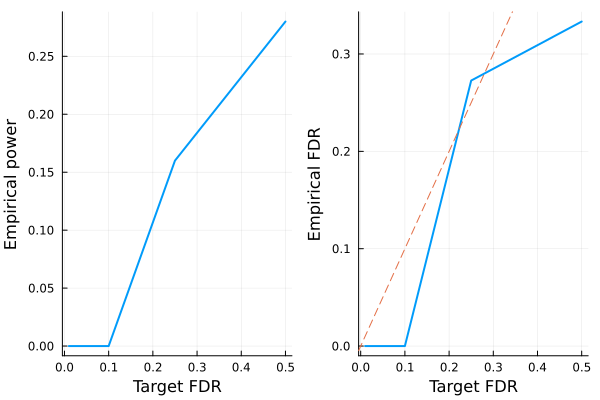

In [43]:
FDR = knockoff_filter.fdr_target
empirical_power = Float64[]
empirical_fdr = Float64[]
for i in eachindex(FDR)
    # extract beta for current fdr
    βknockoff = knockoff_filter.βs[i]
    
    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

**Conclusion:** 

+ LASSO + knockoffs controls the false discovery rate at below the target (dashed line). Thus, one trade power for FDR control. 
+ The power of standard LASSO is better, but it comes with high empirical FDR that one cannot control via cross validation. 

If we repeated the simulation multiple times, we expect the empirical FDR to hug the target FDR more closely.